# Üdvözöllek

Ez a notebook az OTP Bank Nyrt.  Kockázati modellezési osztály kiválasztási eljárásához készült. A célja , hogy a jelölt python - és részben modellezési -  ismereteit felmérje 4 feladaton keresztül. A 4. feladathoz szükséges lehet egy kis kutatásra az interneten amennyiben még nem illesztettél klasszifikációs modellt bináris célváltozóra. A feladatok megoldására a HR -es kolléga által kiküldött email után 1 hét áll rendelkezésre. A megoldásokat notebook formában várjuk az otto.laszlo.schlegl@otpbank.hu email címre.  A kitöltött notebookban szerepeljen a megoldáshoz használt kódrészlet. 

####Feladat 0.
Töltsd le és olvasd be a mappában található csv fájlt (churn_data.csv)

In [82]:
import pandas as pd

file_name = 'churn_data.csv'
df = pd.read_csv(file_name)
#egyszerűbben: df = pd.read_csv('churn_data.csv')

print("Teszt:")
print(df.head())

Teszt:
   CustomerID  Gender  SeniorCitizen  Tenure          StreamingTV  \
0           0  Female              0       4                   No   
1           1    Male              0      27  No internet service   
2           2    Male              0      45                   No   
3           3    Male              0      61                  Yes   
4           4    Male              0      71                  Yes   

         Contract PaperlessBilling            PaymentMethod  MonthlyCharges  \
0  Month-to-month              Yes             Mailed check           45.30   
1        One year               No             Mailed check           20.30   
2        One year              Yes  Credit card (automatic)           95.00   
3        One year              Yes         Electronic check          106.00   
4        Two year              Yes         Electronic check          105.25   

  TotalCharges  Churn  
0       196.95      1  
1       595.05      0  
2      4368.85      0  
3      

#### Feladat 1.

Mekkora az átlag churn ráta a 9 hónapnál régebbi ügyfeleknél a különböző szerződéstípusok esetén? (ha nem ismered a pandassql csomagot, akkor keress más megoldást)

In [83]:
#1.Feladat- v1
df_filtered = df[df['Tenure'] > 9]

average_churn_by_contract = df_filtered.groupby('Contract')['Churn'].mean()

print("Átlagos churn ráta (9+ hónap) szerződéstípusonként:")
print(average_churn_by_contract)

#1.Feladat- v2- pansdassql
import pandasql as psql

query = """
SELECT Contract, AVG(Churn) as avg_churn
FROM df
WHERE Tenure > 9
GROUP BY Contract
"""
# result = psql.sqldf(query, locals())
print("\nÁtlagos churn ráta (9+ hónap) szerződéstípusonként pandassql-lel:")
result = psql.sqldf(query)
print(result)

Átlagos churn ráta (9+ hónap) szerződéstípusonként:
Contract
Month-to-month    0.346606
One year          0.120040
Two year          0.026408
Name: Churn, dtype: float64

Átlagos churn ráta (9+ hónap) szerződéstípusonként pandassql-lel:
         Contract  avg_churn
0  Month-to-month   0.346606
1        One year   0.120040
2        Two year   0.026408


#### Feladat 2.

Vizsgáld meg a lehetséges változók típusát és eloszlását, ahol szükséges, ott kezeld a hiányzó értékeket!

In [84]:
print(df.info())

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Kategóriák:", categorical_cols)
print("Numerikus oszlopok:", numerical_cols)

print("\nNumerikus változók statisztikái:")
print(df.describe())

print("\nKategorikus változók értékeinek eloszlása:")
for col in df.select_dtypes(include='object').columns:
    print(f"\n{col} értékek:")
    print(df[col].value_counts())

print("\nHiányzó értékek száma oszloponként:")
print(df.isnull().sum())
print((df == '').sum())

#TotalCharges object- 9 helyen hiányzik
total_charges_numeric = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("Hiányzó TotalCharges értékek:", total_charges_numeric.isna().sum())
print(df[total_charges_numeric.isna()])

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df['TotalCharges'].isna().sum())

df['TotalCharges'].fillna(0, inplace=True)
#df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
#df = df.dropna(subset=['TotalCharges'])

print("Ellenőrzés: TotalCharges típusa:", df['TotalCharges'].dtype, ", hiányzók:", df['TotalCharges'].isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        5000 non-null   int64  
 1   Gender            5000 non-null   object 
 2   SeniorCitizen     5000 non-null   int64  
 3   Tenure            5000 non-null   int64  
 4   StreamingTV       5000 non-null   object 
 5   Contract          5000 non-null   object 
 6   PaperlessBilling  5000 non-null   object 
 7   PaymentMethod     5000 non-null   object 
 8   MonthlyCharges    5000 non-null   float64
 9   TotalCharges      5000 non-null   object 
 10  Churn             5000 non-null   int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 429.8+ KB
None
Kategóriák: ['Gender', 'StreamingTV', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']
Numerikus oszlopok: ['CustomerID', 'SeniorCitizen', 'Tenure', 'MonthlyCharges', 'Churn']

Numerikus változók s

#### Feladat 3.

Írj egy függvényt, amely a folytonos változókat 10 egyenlő részre osztja.

In [85]:
def binning_features(df, x, grp=10):
    new_df = df.copy()

    new_col = f"{x}_bin"

    new_df[new_col] = pd.qcut(new_df[x], q=grp, duplicates='drop')

    return new_df

df_binned = binning_features(df, 'MonthlyCharges')
print(df_binned[['MonthlyCharges', 'MonthlyCharges_bin']].head())

   MonthlyCharges MonthlyCharges_bin
0           45.30     (25.05, 45.65]
1           20.30     (20.05, 25.05]
2           95.00    (94.3, 102.605]
3          106.00  (102.605, 118.75]
4          105.25  (102.605, 118.75]


#### Feladat 4.

Építs klasszifikációs modellt a churn (célváltozó) előrejelzésére. (pl. a scikit learn csomag felhasználásával)

Értékeld ki a modellt egy független mintán, a bináris célváltozójú klasszifikációs modellekre alkalmazott mutatókkal!

Legjobb küszöb: 0.20, maximális F1: 0.606


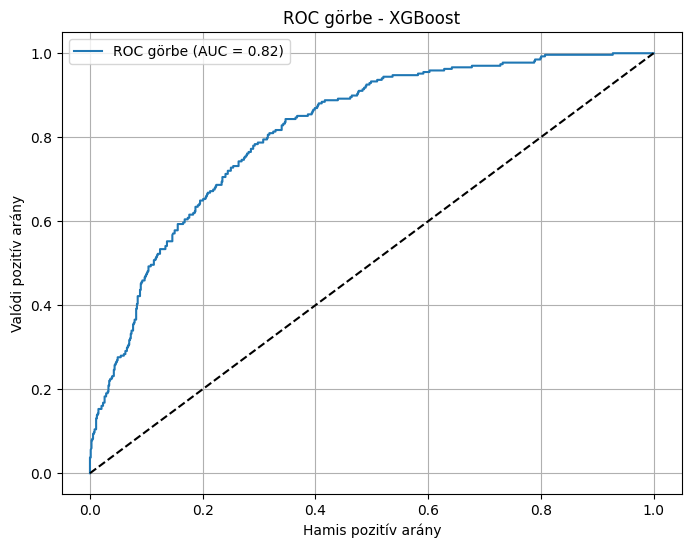

Alap küszöb: 
Jelentés:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       732
           1       0.61      0.52      0.56       268

    accuracy                           0.78      1000
   macro avg       0.72      0.70      0.71      1000
weighted avg       0.77      0.78      0.78      1000

Pontosság : 0.781
Érzékenység (Recall): 0.5223880597014925
Precízió (Precision): 0.6060606060606061
F1-érték: 0.561122244488978
Konfúziós mátrix:
 [[641  91]
 [128 140]]
ROC AUC érték: 0.8160172498164913

Egyéni küszöb
Jelentés:
               precision    recall  f1-score   support

           0       0.90      0.71      0.79       732
           1       0.49      0.78      0.61       268

    accuracy                           0.73      1000
   macro avg       0.70      0.74      0.70      1000
weighted avg       0.79      0.73      0.74      1000

Pontosság: 0.727
Érzékenység: 0.7835820895522388
Precízió: 0.49411764705882355
F1-érték: 0.

In [106]:
#!pip install scikit-learn
#!pip install matplotlib
#!pip install xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

# Cél és magyarázó változók
y = df['Churn']
X = df.drop(columns=['Churn', 'CustomerID'])

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

''' model = Pipeline([
    ('elofeldolgozas', preprocessor),
    ('osztalyozo', RandomForestClassifier(random_state=42, class_weight='balanced'))
]) '''

model = Pipeline([
    ('elofeldolgozas', preprocessor),
    ('osztalyozo', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# 80% tanító, 20% teszt minta
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

# előrejelzés
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

#legjobb küszöbérték
küszöb = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for t in küszöb:
    y_pred_custom = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred_custom)
    f1_scores.append(f1)

legjobb_érték = küszöb[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Legjobb küszöb: {legjobb_érték:.2f}, maximális F1: {best_f1:.3f}")

#ROC görbe ábrázolása
y_pred_custom = (y_prob >= legjobb_érték).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC görbe (AUC = {:.2f})".format(roc_auc_score(y_test, y_prob)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Hamis pozitív arány")
plt.ylabel("Valódi pozitív arány")
plt.title("ROC görbe - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

# eredmények:
print("Alap küszöb: ")
print("Jelentés:\n", classification_report(y_test, y_pred))
print("Pontosság :", accuracy_score(y_test, y_pred))
print("Érzékenység (Recall):", recall_score(y_test, y_pred))
print("Precízió (Precision):", precision_score(y_test, y_pred))
print("F1-érték:", f1_score(y_test, y_pred))
print("Konfúziós mátrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC érték:", roc_auc_score(y_test, y_prob))

print("\nEgyéni küszöb")
print("Jelentés:\n", classification_report(y_test, y_pred_custom))
print("Pontosság:", accuracy_score(y_test, y_pred_custom))
print("Érzékenység:", recall_score(y_test, y_pred_custom))
print("Precízió:", precision_score(y_test, y_pred_custom))
print("F1-érték:", f1_score(y_test, y_pred_custom))
print("Konfúziós mátrix:\n", confusion_matrix(y_test, y_pred_custom))

#ennél jobbat sajnos nem sikerült kihoznom

ertekeles = """
A modell az ügyfelek lemorzsolódásának előrejelzésére közepesen jól teljesít. Az alapértelmezett 0,5-ös küszöb mellett a pontosság 78%, ami azt jelenti, hogy a modell az esetek nagy részében helyesen osztályozza az ügyfeleket. Az érzékenység azonban csak 52%, vagyis az elvesztésre hajlamos ügyfelek kevesebb mint felét ismeri fel, ami üzleti szempontból problémás lehet, hiszen így sok potenciális "lemorzsólódó"" ügyfél „elsiklik” a figyelmünk előtt. A precízió viszont viszonylag magas, 61%, ami azt mutatja, hogy a churn-nek (churn=1) jelölt ügyfelek több mint fele valóban valódi lemorzsolódó. Az F1-érték 0,56 körüli, ami azt tükrözi, hogy a modell egyensúlyt próbál tartani a hamis pozitív és hamis negatív osztályozások között, de még nem optimális.

Ha a küszöböt 0,2-re csökkentjük, az érzékenység javul, eléri a 78%-ot, vagyis több lemorzsolódó ügyfelet tudunk felismerni. Ez azonban a pontosság csökkenésével (73%) és a precízió mérséklődésével (49%) jár, tehát több téves riasztás is lesz. Az F1-érték viszont 0,61-re nő, ami a jobb egyensúlyt jelzi.

Összességében a modell hasznos lehet a churn előrejelzésére, különösen az érzékenység növelésével, ami fontosabb lehet az üzleti szempontból, hogy több potenciális lemorzsolódó ügyfelet azonosítsunk, még akkor is ha ezek között több lesz a "téves riasztás".
"""
print(ertekeles)
